Имеется набор данных, содержащий определённую информацию о человеке:

* wage -- почасовая заработная плата
* exper -- опыт работы (кол-во лет)
* union -- состоит ли в профсоюзе
* goodhlth -- хорошее ли здоровье
* black -- принадлежит ли афроамериканской расе
* female -- женщина ли
* married -- состоит ли в браке
* service -- работает ли в сфере услуг
* educ -- годы обучения
* looks -- оценка внешнего вида $(\overline{1,5})$
 
*Целью* работы является выявление общих тенденций и обучение модели оценивать внешний вид человека. 

Так как признак looks является категориальным, то последняя часть цели представляет из себя задачу классификации, но при этом её можно решить как задачу регрессии, так как здесь можно считать, что $1 < 5$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('beauty.csv', sep=';')

In [3]:
df.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


In [4]:
print('Данные содержат {} объектов и {} признаков'.format(df.shape[0], df.shape[1]))

Данные содержат 1260 объектов и 10 признаков


## Выявление общих тенденций

В данных присутствуют три количественных признака, это 'wage', 'exper' и 'educ'. Поисследуем их.

In [5]:
df[['wage', 'exper', 'educ']].describe()

,wage,exper,educ
count,1260.000000,1260.000000,1260.000000
mean,6.306690,18.206349,12.563492
std,4.660639,11.963485,2.624489
min,1.020000,0.000000,5.000000
25%,3.707500,8.000000,12.000000
50%,5.300000,15.000000,12.000000
75%,7.695000,27.000000,13.000000
max,77.720000,48.000000,17.000000


В признаке 'wage' присутствуют выбросы, так как медиана равна 5.3, 75 квантиль равна 7.7, при этом максимальное значение в выборке равно 77.7. 

Объекта с 'wage' = 77.7 можно исключить из выборки, а можно подумать, что при записи числа запятая была поставлена в неправильном месте, и поставить запятаю в нужно место. Я воспользуюсь вторым способом.

In [6]:
df['wage'] .iloc[602]= 7.772

In [7]:
df[['wage', 'exper', 'educ']].describe()

,wage,exper,educ
count,1260.000000,1260.000000,1260.000000
mean,6.251176,18.206349,12.563492
std,4.203505,11.963485,2.624489
min,1.020000,0.000000,5.000000
25%,3.707500,8.000000,12.000000
50%,5.300000,15.000000,12.000000
75%,7.695000,27.000000,13.000000
max,41.670000,48.000000,17.000000


Максимальное значение всё ещё далеко от медианы, но не так далеко, как 77.7, так что 77.7 всёже правильно считать выбросом. Посмотрим на гистограмму этого признака.

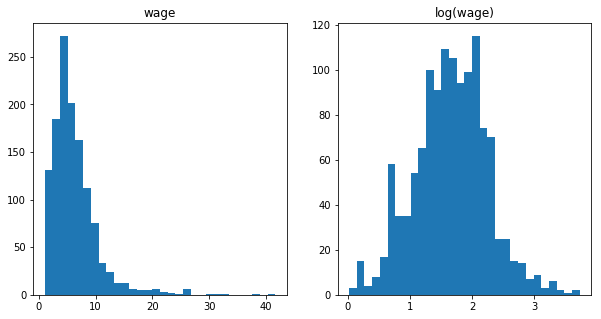

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(df['wage'], bins=30);
plt.title('wage')

plt.subplot(122)
plt.hist(np.log(df['wage']), bins=30);
plt.title('log(wage)');

Гистограммы нам говорят, что признак 'wage' имеет логистическое распределение. Для построение регрессионной прямой (плоскости) лучше прологарифмировать этот признак (сделать его значения нормально распределёнными), а сделаем мы это после выявления общих тенденций.

**1. Как отличается размер ежедневного заработка женщин и мужчин?**
> Женщины в среднем получают в два раза меньше зарплату, нежели мужчины, возможно это связано с тем, что у женщин опыт работы также в два раза меньше, чем у мужчин.

In [9]:
df.groupby('female')[['wage', 'exper', 'educ']].agg([len,np.median])

wage        exper        educ       
          len median   len median  len median
female                                       
0       824.0   6.41   824   18.0  824     12
1       436.0   3.75   436   11.5  436     12

**2. Наличие брака влияет на какие-нибудь признаки?**
> В среднем женатые мужчины зарабатывают на две условные единицы денег в день больше, чем неженатые. И женяться мужчины в более зрелом возрасте, нежели женщины (это можно понять по признаку 'exper': женатые мужчины в среднем работают уже 20 лет, а неженатые 9).

>У женщин же всё более-менее одинаково в этом плане.

In [10]:
pd.pivot_table(df, columns='married',index='female', aggfunc=np.median)

black       educ       exper       goodhlth      looks      service  \
married     0    1     0     1     0     1        0    1     0    1       0   
female                                                                        
0         0.0  0.0  12.0  12.0   9.0  20.5      1.0  1.0   3.0  3.0     0.0   
1         0.0  0.0  12.0  12.0  10.0  12.0      1.0  1.0   3.0  3.0     0.0   

             union        wage        
married    1     0    1      0     1  
female                                
0        0.0   0.0  0.0  5.065  6.71  
1        0.0   0.0  0.0  3.890  3.58

**3. Можно ли считать, что белокожие красивей темнокожих или наоборот?**
>Исходя из гистограммы ниже, можно сделать заключение, что среди людей с оценкой внешнисти меньше средней (< 3) встречается больше белокожих людей, нежели темнокожих. То есть, если взять двух рандомных людей, один из которых темнокожий, а другой белокожий, то вероятность быть красивым у темнокожего больше. 

Очень некрасивых и очень красивых людей очень мало, поэтому заменю 1 на 2, а 5 на 4.

Белокожих людей в выборке в 10 раз больше, чем темнокожих, если эти данные нормировать, то из-за большого количества данных можно получить смещённую оценку. Чтобы этого избежать, мной было решено 5 раз выбрать любых 93 белокожих человека (так как темнокожих 93), каждый раз считать количество людей в каждой группе красоты, а результат усреднить.

In [11]:
def v_c(data):
    return data.value_counts()

In [12]:
v_c(df['looks'])

3    722
4    364
2    142
5     19
1     13
Name: looks, dtype: int64

In [13]:
df['looks'] = df['looks'].replace([1,5], [2,4]);

In [14]:
df['black'].value_counts()

0    1167
1      93
Name: black, dtype: int64

In [15]:
dict_data = {2:[],3:[],4:[]}
for _ in range(5):
    data = df[df['black']==0]['looks'].sample(93)
    l = v_c(data)
    for i in l.keys():
        dict_data[i].append(l[i])

In [16]:
b = [np.array(dict_data[i]).mean() for i in range(2,5)]

In [17]:
a = v_c(df[df['black']==1]['looks']).sort_index().values

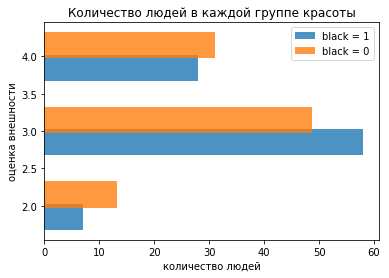

In [18]:
plt.barh(np.arange(2,len(a)+2)-0.15,a,0.35, alpha=0.8, label='black = 1');
plt.barh(np.arange(2,len(b)+2)+0.15,b,0.35, alpha=0.8, label='black = 0');
plt.xlabel('количество людей')
plt.ylabel('оценка внешности')
plt.title('Количество людей в каждой группе красоты')
plt.legend();


## Построение регрессионной прямой и классификации

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, f1_score, accuracy_score

Как в начале упоменалось, произведём логарифмирование признака 'wage'. Затем разделим данные на тестовую и тренировочную выборки.

In [20]:
df['wage'] = np.log(df['wage'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('looks',1), df['looks'], test_size=0.3)

У построенной линейной регрессии метрика mean_absolute_error = 0.48.

In [22]:
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
mae(y_pred, y_train)

0.4807311456044211

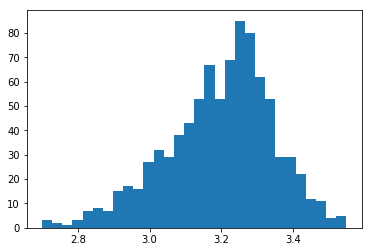

In [23]:
plt.hist(y_pred, 30);

Построенное дерево решений обладает предсказательной способностью немного хуже, метрика mean_absolute_error = 0.60. 

In [24]:
tree = DecisionTreeClassifier(criterion='gini', random_state=20)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
mae(y_pred, y_test)

0.6005291005291006

Из двух построенных моделей следует выбрать линейную регрессии, так как чем меньше метрика mean_absolute_error, тем лучше.

В ходе работы была достигнута поставленная цель.